In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
df = pd.read_csv('../data/online_retail_cleaned_v2.csv', parse_dates=['InvoiceDate'], index_col=False)
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52933 entries, 0 to 52932
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   InvoiceNo    52933 non-null  int64         
 1   StockCode    52933 non-null  object        
 2   Description  52933 non-null  object        
 3   Quantity     52933 non-null  int64         
 4   InvoiceDate  52933 non-null  datetime64[ns]
 5   UnitPrice    52933 non-null  float64       
 6   CustomerID   39573 non-null  float64       
 7   Country      52933 non-null  object        
 8   Revenue      52933 non-null  float64       
 9   Year         52933 non-null  int64         
 10  Month        52933 non-null  int64         
 11  DayName      52933 non-null  object        
 12  Hour         52933 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(5), object(4)
memory usage: 5.3+ MB
None


Defining the Snapshot Date:

* Before calculating RFM, we need a reference point in time, commonly called the snapshot date.

In [3]:
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
print('Snapshot_date is defined.')

Snapshot_date is defined.


Aggregating Transactions at the Customer Level

In [4]:
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'Revenue': 'sum'
})

print('Aggregated Transactions at the Customer Level')

Aggregated Transactions at the Customer Level


Renaming Columns for Clarity

In [5]:
rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'Revenue': 'Monetary',
}, inplace=True)

print('Columns are renamed.')

Columns are renamed.


Inspecting the Result

In [6]:
print(rfm.head(10))

            Recency  Frequency  Monetary
CustomerID                              
12346.0         326          1  77183.60
12347.0           2          7    412.60
12348.0         319          2    323.52
12349.0          19          1    186.04
12350.0         310          1     42.90
12352.0          72          5    319.95
12353.0         204          1     59.70
12354.0         232          1     41.35
12355.0         214          1    165.30
12356.0         326          1    193.40


In [7]:
rfm.describe()

,Recency,Frequency,Monetary
count,3789.000000,3789.000000,3789.000000
mean,98.696226,3.398786,242.184975
std,101.296520,5.766635,1544.366709
min,1.000000,1.000000,0.390000
25%,21.000000,1.000000,32.850000
50%,58.000000,2.000000,77.990000
75%,157.000000,4.000000,194.500000
max,374.000000,163.000000,77183.600000


Turning RFM Numbers Into Meaningful Customer Segments:



In [8]:
# Step 1: Ranking Customers by Each RFM Metric
def rfm_score(series, ascending=True, n_bins=5):
    # Rank the values to ensure uniqueness
    ranked = series.rank(method='first', ascending=ascending)
    # Use pd.qcut on the ranks to assign bins
    return pd.qcut(ranked, q=n_bins, labels=range(1, n_bins+1)).astype(int)

In [9]:
# Step 2: Applying the Scores
# Assign R, F, M scores
rfm['R_score'] = rfm_score(rfm['Recency'], ascending=False)  # Recent purchases = high score
rfm['F_score'] = rfm_score(rfm['Frequency'])  # More frequent = high score
rfm['M_score'] = rfm_score(rfm['Monetary'])  # Higher spend = high score

In [10]:
# Step 3: Creating a Combined RFM Score
rfm['RFM_score'] = (
    rfm['R_score'].astype(str)+
    rfm['F_score'].astype(str)+
    rfm['M_score'].astype(str)
)

Translating RFM Scores Into Customer Segments

In [11]:
# Step 1: Defining Segments (Champions, Loyal Customers, Big Spenders, At-Risk, Lost, Promising / New)

# Step 2: Mapping Scores to Segments
def rfm_segment(row):
    if row['R_score'] >= 4 and row['F_score'] >= 4 and row['M_score'] >= 4:
        return 'Champions'
    elif row['F_score'] >= 4:
        return 'Loyal Customers'
    elif row['M_score'] >= 4:
        return 'Big Spenders'
    elif row['R_score'] <= 2:
        return 'At-Risk'
    else:
        return 'Others'

rfm['Segment'] = rfm.apply(rfm_segment, axis=1)

print('RFM scores are mapped into human readable labels')

RFM scores are mapped into human readable labels


In [12]:
rfm.head()

,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_score,Segment
CustomerID,,,,,,,,
12346.0,326,1,77183.60,1,1,5,115,Big Spenders
12347.0,2,7,412.60,5,5,5,555,Champions
12348.0,319,2,323.52,1,3,5,135,Big Spenders
12349.0,19,1,186.04,4,1,4,414,Big Spenders
12350.0,310,1,42.90,1,1,2,112,At-Risk


In [18]:
rfm_log = rfm.copy()
rfm_log[['Recency', 'Frequency', 'Monetary']] = rfm_log[['Recency', 'Frequency', 'Monetary']].applymap(lambda x: np.log1p(x))

C:\Users\being\AppData\Local\Temp\ipykernel_5884\221808621.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  rfm_log[['Recency', 'Frequency', 'Monetary']] = rfm_log[['Recency', 'Frequency', 'Monetary']].applymap(lambda x: np.log1p(x))


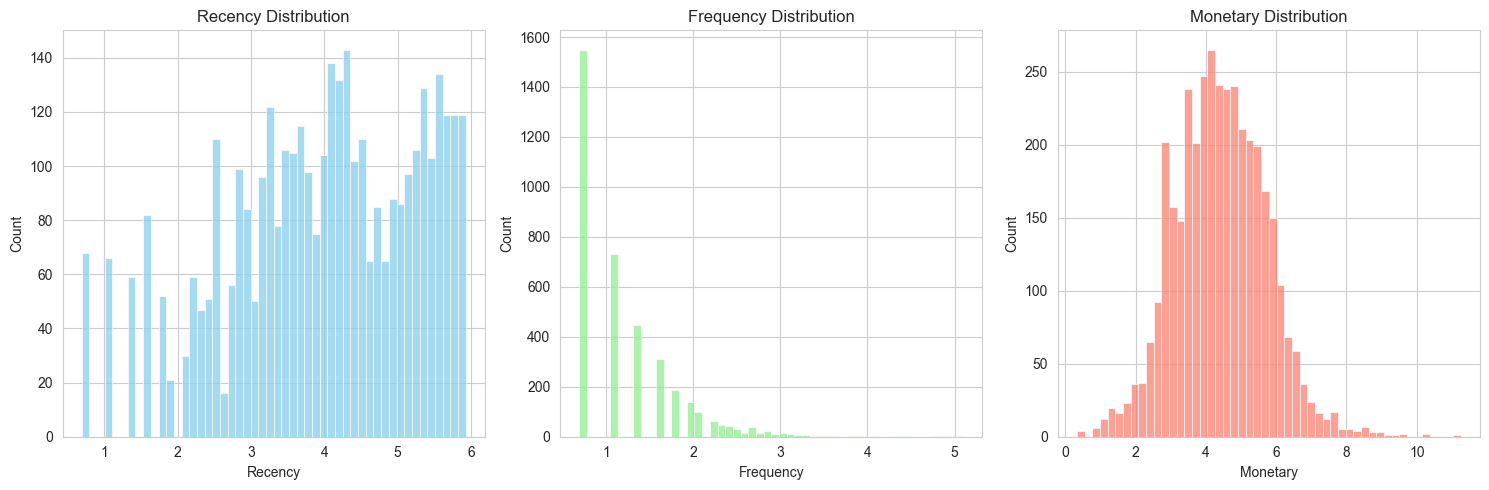

In [24]:
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
sns.histplot(rfm_log['Recency'], bins=50, kde=False, color="skyblue")
plt.title("Recency Distribution")

plt.subplot(1,3,2)
sns.histplot(rfm_log['Frequency'], bins=50, kde=False, color="lightgreen")
plt.title("Frequency Distribution")

plt.subplot(1,3,3)
sns.histplot(rfm_log['Monetary'], bins=50, kde=False, color="salmon")
plt.title("Monetary Distribution")

plt.tight_layout()
plt.show()